In [2]:
import os
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
from image_inpainting.datamodule.tiny_image_net_data_module import TinyImageNetDataModule
from pytorch_lightning.callbacks import ModelCheckpoint
from image_inpainting.model.context_encoder import ContextEncoder
from image_inpainting.utils import print_results_images

In [3]:
from datetime import datetime
now = datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")

## Create datamodule

In [4]:
data_dir = "data"

dm = TinyImageNetDataModule(
    data_dir=os.path.join(data_dir, "tiny-imagenet-200"), 
    batch_size_train=512,
    batch_size_val=512,
    batch_size_test=512,
    num_workers=10, 
    pin_memory=True, 
    persistent_workers=True,
)

## Create a ContextEncoder model from scratch

In [5]:
# except from results this is the only difference with the other notebooks for tiny imagenet
model = ContextEncoder(input_size=(3, 128, 128), hidden_size=4000, save_image_per_epoch=True, reconstruction_loss_weight = 0.99, adversarial_loss_weight = 0.01)

## Or load it from a checkpoint

In [ ]:
# model = ContextEncoder.load_from_checkpoint("checkpoints/tiny_imagenet_100_factor_losses_coefficients/epoch=54-step=171930.ckpt") # change the path to your checkpoint
# model.enable_save_image_per_epoch()
# model.to("cuda")

## Train it

In [6]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/tiny_imagenet_100_factor_losses_coefficients',
    filename=now+'-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_top_k=-1,  # Save all checkpoints
    every_n_epochs=1  # Save checkpoint every n epochs
)

tb_logger = pl_loggers.TensorBoardLogger("Context_Encoder_Inpainting")
trainer = pl.Trainer(max_epochs=300, devices=-1, accelerator="cuda", logger=tb_logger, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model, dm)

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                     | Params | Mode 
-------------------------------------------------------------------
0 | psnr_metric   | PeakSignalNoiseRatio     | 0      | train
1 | joint_loss    | JointLoss                | 0      | train
2 | rec_loss      | ReconstructionLoss       | 0      | train
3 | adv_loss      | AdversarialLoss          | 0      | train
4 | generator     | AdversarialGenerator     | 71.1 M | train
5 | discriminator | AdversarialDiscriminator | 2.8 M  | train
-------------------------------------------------------------------
73.9 M    Trainable par

Epoch 26:  99%|█████████▉| 1545/1563 [02:32<00:01, 10.16it/s, v_num=18, train_psnr=18.30, train_loss_context_encoder=2.140, train_loss_discriminator=2.41e-5, val_psnr=15.40, val_loss=4.920] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

A notebook "tensorboard" exists if you want to check how the metrics evolve during training

## Display some images and evaluate the model performances

Here the results of this cell are after 63 epochs on the Tiny Image Net dataset (10x less images compared to Image Net) in 64x64

- **Number of steps**: 100 000
- **Time**: 3h10
- **Observation (with tensorboard)**: Like the test on factor 10, we seem to have better results compared to the 0.999 and 0.001 $\lambda$ parameters for the loss coefficients, and we have similar observations here. But we have a less noisy/sharp image, with less artefacts here. But some are still left. We might want to rey running it for longer to see if those artefacts remain.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:03<00:00, 48.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Final PSNR           15.349081039428711
        test_loss            5.010585784912109
        test_psnr           15.352187156677246
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


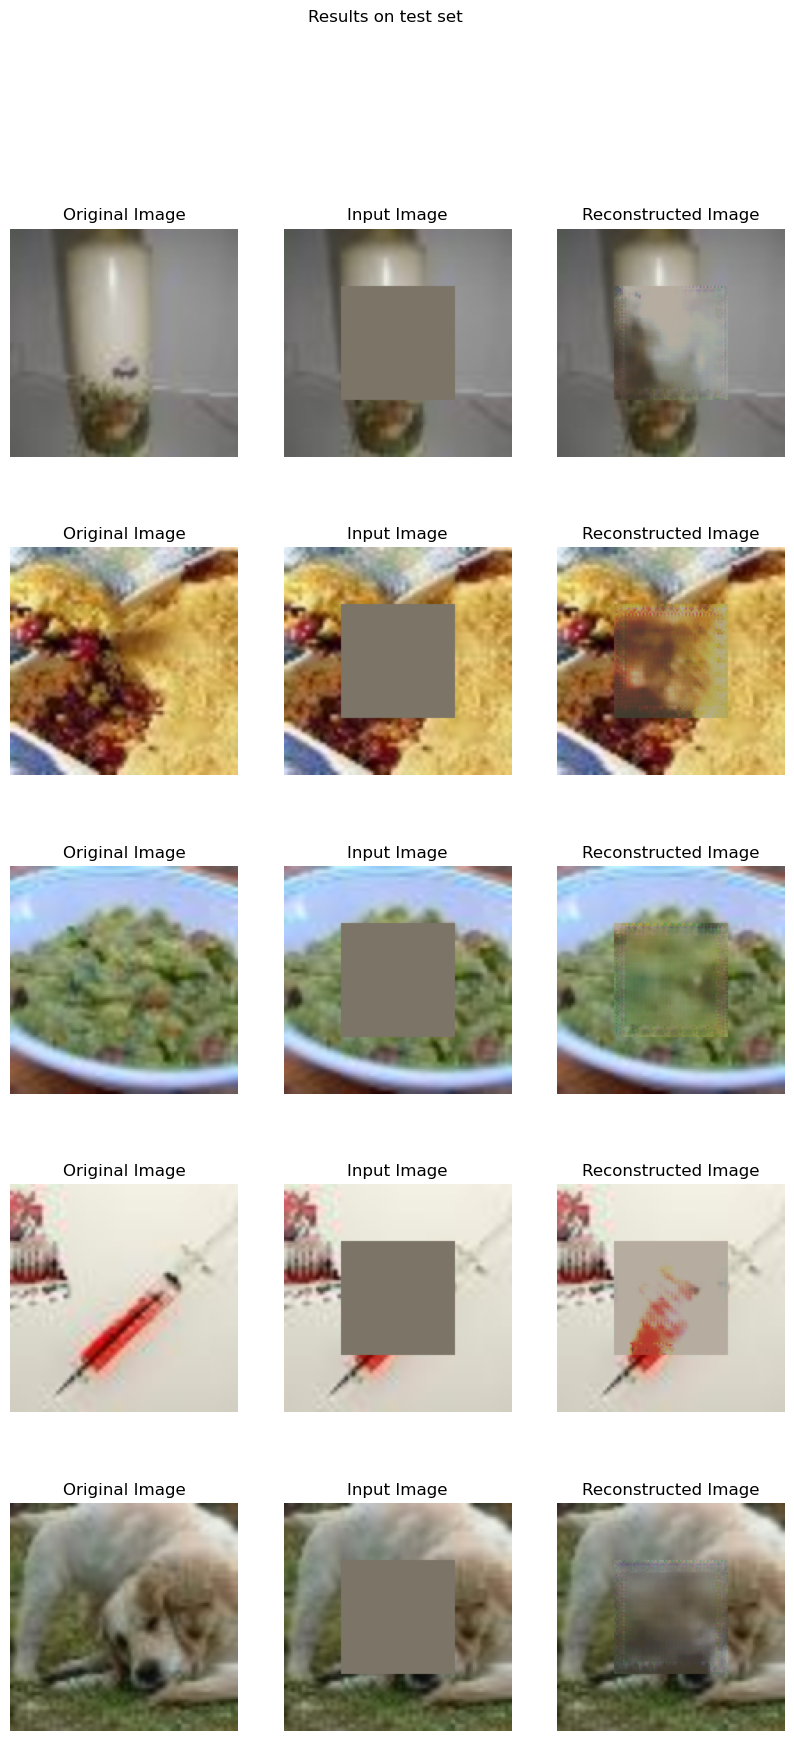

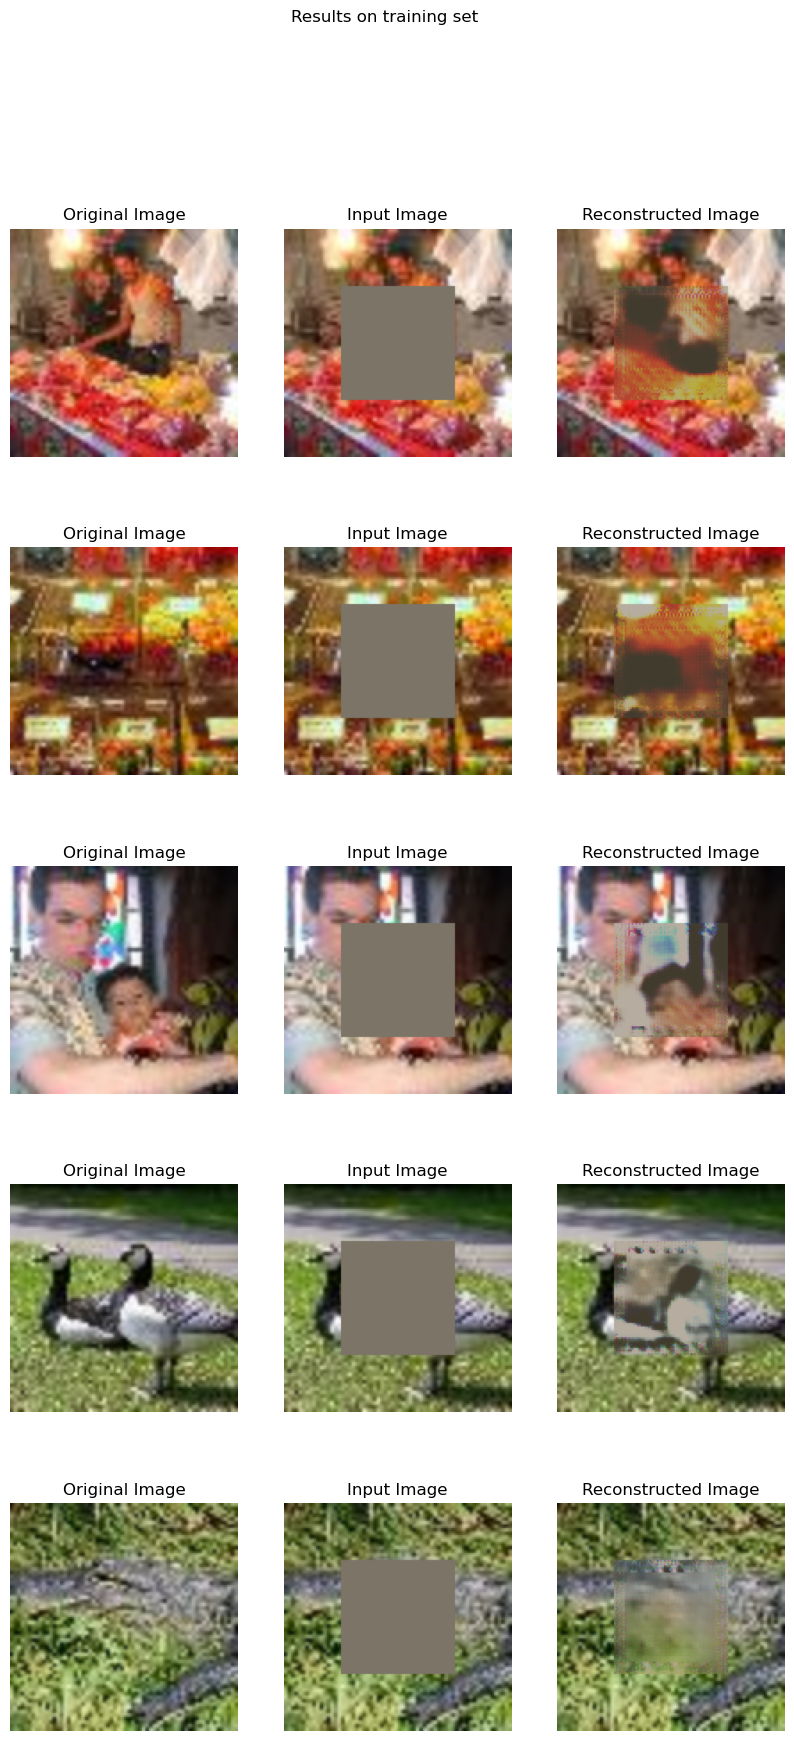

In [8]:
trainer.test(model, dm)

x, y = next(iter(dm.test_dataloader()))
    
x = x.to(model.device)
y = y.to(model.device)

out = model.forward(x)

print_results_images(x, y, out, "Results on test set", dm.inverse_transform)

dm.setup("fit") # in case "fit" wasn't called before this cell

x, y = next(iter(dm.train_dataloader()))
x = x.to(model.device)
y = y.to(model.device)
out = model.forward(x)

print_results_images(x, y, out, "Results on training set", dm.inverse_transform)